# Data 200 - Grad Project

Sverre Rynning-Tønnesen, Isabel Slorer, Hans Erik Heum

## Structure


1) Introduction <br>
2) Data Sampling and Collection <br>
3) Data Cleaning <br>
4) Exploratory Data Analysis <br>
5) Feature Engineering <br>
6) Data Modeling and Inferences <br>
7) Conclusion <br>

### Introduction

This notebook is meant to complement the project writeup and give an understanding of how we have collected, processed and modeled all the data displayed in the writeup. We will describe the steps we have taken with both code and text but to get a full understanding of the project, its goal and results we suggest reading this together with the writeup

### Data Sampling and Collection

To run our notebook a few libraries have to be downloaded. We have experienced some issues with installing and importing the different libraries on different computers. The errors may occur due to different already downloaded packages on different computers. If you run into any import errors, we are very sorry for the inconvenience. 

In [ ]:
import sys
!brew install libomp
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install pystan
!{sys.executable} -m pip install fbprophet

In [337]:
#Load all important libraries
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import datetime

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge

import plotly as go
import plotly.graph_objects as go

import plotly.graph_objs as go
import pandas as pd
from plotly.offline import iplot, init_notebook_mode
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import xgboost as xgb
import lightgbm as lgb

import fbprophet
from fbprophet import Prophet

### Import necessary datasets

#### Import Covid Restrictions Data (KFF)
The first dataframe we download contains information about multiple covid restrictions in the US for all the states. The data is between 2020-06-04 and 2021-11-09 and is taken from KFF (Kaiser Family Foundation) which is a nonprofit organization focusing on national health issues, as well as the U.S. role in global health policy.

The information has been updated daily and compiled from a review of state executive orders, guidance documents, policy bulletins, and news releases. There are some missing values in the dataset because of the different methods used to gather the data but the data should not be affected by either selection bias, response bias no non-response bias.

In [338]:

#initialize state_social_distancing_d
def init_state_social_distancing_actions(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        if date == "20201-06-01":
          date = "2021-06-01"
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Unnamed: 0':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

state_social_distancing_actions = init_state_social_distancing_actions(r'../data/state_social_distancing_actions.zip')



#### Import additional covid restrictions data (openICPSR)
The restrictions data collected from openICPSR contains also contains information about a lot of restrictions that were put in place in different states. Some restrictions were reinstated multiple times and some were just imposed once, but this varied for state to state. The data is has continously been updated until we downloaded it and contains data from the first restrictions were imposed, which is the start of March 2020. The data is taken from openICPSR which is a webservice for sharing data collections.

The data we downloaded is from a dataset called "COVID-19 US State Policy Database" which is operated by the Boston University School of Public Health. This dataset is made by looking over different state sites and gathering the data from them. The exact source for each feature can be found in [openICPSR sources](https://www.dropbox.com/sh/z8mhrb0r1t4rlqu/AABeyqlymGA-HclJ907BfnUGa?dl=0). The fact that all the data is gathered from a lot of different sites makes it really time consuming to verify if it is unbiased and correct. Also, because the dataset contains the start and end date for when the restrictions were put in place there are not missing data. However, since most of the restrictions were imposed in the start of the pandemic and removed within 1 year there are not much data covering the last year.


In [339]:
def init_restriction_df(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

restrictions_df = init_restriction_df(r'../data/updated_restrictions.csv.zip', ["STATE"])

#### Import vaccination data

The vaccination data is taken from CDC (Center for Disease Control and Prevention). It contains time specific information about the distribution and administration for different vaccines in different states. The data range is from 2020-12-14 to 2022-04-20.

The data contained in the database have been gathered by CDC themselves and the database have been updated daily.

In [340]:
def init_vaccination_df_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

vaccination_df = init_vaccination_df_from_zip(r'../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv.zip', ["Date"])
vaccination_df = vaccination_df[vaccination_df["Location"] == "CA"]
vaccination_df.index = pd.to_datetime(vaccination_df.index)
vaccination_df.sort_index(inplace=True)
vaccination_df.head(5)

MMWR_week Location  Distributed  Distributed_Janssen  \
Date                                                               
2020-12-14         51       CA        33150                    0   
2020-12-15         51       CA       148200                    0   
2020-12-16         51       CA       195000                    0   
2020-12-17         51       CA       326625                    0   
2020-12-18         51       CA       326625                    0   

            Distributed_Moderna  Distributed_Pfizer  Distributed_Unk_Manuf  \
Date                                                                         
2020-12-14                    0                   0                      0   
2020-12-15                    0                   0                      0   
2020-12-16                    0                   0                      0   
2020-12-17                    0                   0                      0   
2020-12-18                    0                   0                      0   

            Dist_Per_100K  Distributed_Per_100k_12Plus  \
Date                                                     
2020-12-14             84                            0   
2020-12-15            375                            0   
2020-12-16            494                            0   
2020-12-17            827                            0   
2020-12-18            827                            0   

            Distributed_Per_100k_18Plus  ...  \
Date                                     ...   
2020-12-14                            0  ...   
2020-12-15                            0  ...   
2020-12-16                            0  ...   
2020-12-17                            0  ...   
2020-12-18                            0  ...   

            Administered_Dose1_Recip_5PlusPop_Pct  Series_Complete_5Plus  \
Date                                                                       
2020-12-14                                    0.0                    0.0   
2020-12-15                                    0.0                    0.0   
2020-12-16                                    0.0                    0.0   
2020-12-17                                    0.0                    0.0   
2020-12-18                                    0.0                    0.0   

            Series_Complete_5PlusPop_Pct  Administered_5Plus  \
Date                                                           
2020-12-14                           0.0                 0.0   
2020-12-15                           0.0                 0.0   
2020-12-16                           0.0                 0.0   
2020-12-17                           0.0                 0.0   
2020-12-18                           0.0                 0.0   

            Admin_Per_100k_5Plus  Distributed_Per_100k_5Plus  \
Date                                                           
2020-12-14                   0.0                         0.0   
2020-12-15                   0.0                         0.0   
2020-12-16                   0.0                         0.0   
2020-12-17                   0.0                         0.0   
2020-12-18                   0.0                         0.0   

            Series_Complete_Moderna_5Plus  Series_Complete_Pfizer_5Plus  \
Date                                                                      
2020-12-14                            NaN                           NaN   
2020-12-15                            NaN                           NaN   
2020-12-16                            NaN                           NaN   
2020-12-17                            NaN                           NaN   
2020-12-18                            NaN                           NaN   

            Series_Complete_Janssen_5Plus  Series_Complete_Unk_Manuf_5Plus  
Date                                                                        
2020-12-14                            NaN                              NaN  
2020-12-15                            NaN               

#### Import death rate data
The data repository containing data about the death rate is operated by JHUCSSE (Johns Hopkins University Center for System Science and Engineering). They have gathered data from multiple different sources which can be found at this address. The data range is between 2020-04-12 and 2022-03-29. Also, becuase the data is gathered from so many different sources it is hard to tell whether it it subject to a bias or not.

In [341]:
def init_daily_reports(path):
  df_master = pd.DataFrame()
  flag = False
  files_in_folder = glob.glob(path)
  for filename in files_in_folder:    
    zip_file = ZipFile(filename)
    for text_file in zip_file.infolist():
      # if not text_file.filename.startswith('__MACOSX/'):
      if text_file.filename.endswith('.csv'):
        date = re.search('\d*-\d*-\d*', text_file.filename)[0]
        date_time_value = pd.to_datetime(date)
        df = pd.read_csv(zip_file.open(text_file.filename), sep=",", header=0)
        df["Date"] = date_time_value
        df.rename(columns = {'Province_State':'State'}, inplace = True)
        df.drop((df[df.State.isin(["United States"])].index) | (df[df.State.isnull()].index), inplace=True)
      if not flag:
        df_master = df
        flag = True
      else:
        df_master = pd.concat([df_master, df])
  df_master.set_index(["Date", "State"], inplace=True)
  df_master.sort_index(inplace=True)
  return df_master

covid_daily_reports = init_daily_reports(r'../data/csse_covid_19_daily_reports_us.zip')

#### Import infection data
The infection data is taken from CDC (Center for Disease Control and Prevention). It contains date specific information about the current number of people infected by Covid-19 in different states. The data range is from 2020-01-22 to 2022-04-18. The data contained in the database have been gathered by CDC themselves and posted daily.

This data is not completely accurate and the reason for this is that it is impossible for CDC to count exact the exact number of covid infections at a given time. COVID-19 can cause mild illness, symptoms might not appear immediately, there are delays in reporting and testing, not everyone who is infected gets tested or seeks medical care, and there are differences in how completely states and territories report their cases

In [342]:
def init_infection_dataframe_from_zip(path, index_col):
    df_master = pd.read_csv(glob.glob(path)[0], compression='zip', header=0, sep=',', index_col=index_col)
    return df_master

infected_df = init_infection_dataframe_from_zip(r'../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv.zip', ["submission_date", "state"])

#### Import death counts by sex, age & state

The death count data is also taken from CDC. It contains time specific information about the number different death cases together with state, age and sex. The data range is between 01/01/2020 and 04/23/2022.

The provisional counts for coronavirus disease 2019 (COVID-19) deaths are based on a current flow of mortality data in the National Vital Statistics System. One should note that this data might not be 100% accurate. The reason is (as explained by CDC):

- National provisional counts include deaths occurring within the 50 states and the District of Columbia that have been received and coded as of the date specified. It is important to note that it can take several weeks for death records to be submitted to National Center for Health Statistics (NCHS), processed, coded, and tabulated. Therefore, the data shown on this page may be incomplete, and will likely not include all deaths that occurred during a given time period, especially for the more recent time periods.

In [343]:
df_sex_age = pd.read_csv('../data/cdc_death_counts_by_sex_age_state.zip',header=0)
df_sex_age.head(5)


Data As Of  Start Date    End Date     Group  Year  Month          State  \
0  03/23/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
1  03/23/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
2  03/23/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
3  03/23/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
4  03/23/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   

         Sex     Age Group  COVID-19 Deaths  Total Deaths  Pneumonia Deaths  \
0  All Sexes      All Ages         974282.0     7520550.0          855731.0   
1  All Sexes  Under 1 year            242.0       41777.0             495.0   
2  All Sexes    0-17 years            933.0       74176.0            1460.0   
3  All Sexes     1-4 years            113.0        7791.0             293.0   
4  All Sexes    5-14 years            296.0       12438.0             424.0   

   Pneumonia and COVID-19 Deaths  Influenza Deaths  \
0                       504882.0           10684.0   
1                           28.0              28.0   
2                          252.0             204.0   
3                           29.0              70.0   
4                           96.0              82.0   

   Pneumonia, Influenza, or COVID-19 Deaths Footnote  
0                                 1334231.0      NaN  
1                                     736.0      NaN  
2                                    2342.0      NaN  
3                                     447.0      NaN  
4                                     705.0      NaN

#### Import death counts by conditions

The death count data is also taken from CDC. It contains time specific data about Covid-19 related deaths including potential contributing causes. The data range is between 01/01/2020 and 04/23/2022.

As with the "death counts by sex, age & state" data, this data will not be a 100% accurate based on the same reasoning.

In [344]:
df_condition = pd.read_csv('../data/cdc_death_counts_by_conditons.zip',header=0)
df_condition.head(5)


Data As Of  Start Date    End Date     Group  Year  Month          State  \
0  03/20/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
1  03/20/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
2  03/20/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
3  03/20/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   
4  03/20/2022  01/01/2020  03/19/2022  By Total   NaN    NaN  United States   

        Condition Group                Condition ICD10_codes Age Group  \
0  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
1  Respiratory diseases  Influenza and pneumonia     J09-J18     25-34   
2  Respiratory diseases  Influenza and pneumonia     J09-J18     35-44   
3  Respiratory diseases  Influenza and pneumonia     J09-J18     45-54   
4  Respiratory diseases  Influenza and pneumonia     J09-J18     55-64   

   COVID-19 Deaths  Number of Mentions Flag  
0           1277.0              1334.0  NaN  
1           5351.0              5551.0  NaN  
2          14089.0             14644.0  NaN  
3          35120.0             36444.0  NaN  
4          76708.0             79386.0  NaN

#### Import Anxiety and Depression data

The anxiety and depression data is also taken from CDC. It shows the percentage of different age groups who have reported symptoms of anxiety and depression over different time periods. The data is gathered in three different periods/phases. Phase 1 was between April 23, 2020 and July 21, 2020. Phase 2 occured between August 19, 2020 and October 26, 2020. Phase 3 occurred between October 28, 2020 and March 29, 2021.

The data was gathered through a 20-minute online survey. It was conducted by an internet questionnaire, with invitations to participate sent by email and text message. Housing units linked to one or more email address or phone number were randomly selected to participate. And the estimates are weighted to adjust for non-response bias. However, the data might still be affected by the non-response bias. In addition the responses are probably affected by selection and response bias as well. Because not all houses have a contact person listed with a phone or mail it is not representative for the whole population, and it is hard to validate if the information given was correct.

In [345]:
df_anx_dep = pd.read_csv('../data/nchs_covid_indicators_of_anxiety_depression.zip',header=0)
df_anx_dep.head(5)


Indicator              Group          State  \
0  Symptoms of Depressive Disorder  National Estimate  United States   
1  Symptoms of Depressive Disorder             By Age  United States   
2  Symptoms of Depressive Disorder             By Age  United States   
3  Symptoms of Depressive Disorder             By Age  United States   
4  Symptoms of Depressive Disorder             By Age  United States   

        Subgroup Phase  Time Period     Time Period Label  \
0  United States     1            1  Apr 23 - May 5, 2020   
1  18 - 29 years     1            1  Apr 23 - May 5, 2020   
2  30 - 39 years     1            1  Apr 23 - May 5, 2020   
3  40 - 49 years     1            1  Apr 23 - May 5, 2020   
4  50 - 59 years     1            1  Apr 23 - May 5, 2020   

  Time Period Start Date Time Period End Date  Value  Low CI  High CI  \
0             04/23/2020           05/05/2020   23.5    22.7     24.3   
1             04/23/2020           05/05/2020   32.7    30.2     35.2   
2             04/23/2020           05/05/2020   25.7    24.1     27.3   
3             04/23/2020           05/05/2020   24.8    23.3     26.2   
4             04/23/2020           05/05/2020   23.2    21.5     25.0   

  Confidence Interval Quartile Range  
0         22.7 - 24.3            NaN  
1         30.2 - 35.2            NaN  
2         24.1 - 27.3            NaN  
3         23.3 - 26.2            NaN  
4         21.5 - 25.0            NaN

## 2. Data Cleaning

Clean up the dataframe to remove unused columns and solve for Nan fields.

- Have to manually insert face mask requirements for recent months based on: https://statepolicies.com/data/graphs/face-masks/
- Face mask mandate was reintroduced from Dec 15, 2021 -> Feb 15, 2022
Other changes

- Manually inserted "No Limit" after 2021-08-15 because missing data
### Clean restriction data

The rows in the restriction data contain information about the dates that the restrictions have changed and shows the data for each state. This means that the data has missing values for all the dates where there was no updates. In addition the dataset have a lot of missing values which we had to handle in different ways depending on the specific restrictions. We also chose to just look at California.
The steps taken to clean the data was:

- Fill inn all the dates with missing data. Because the data had not changed on the missing days we filled the gaps with the same data as the previous valid row.
- For the face mask restriction we had to manually fix the dataset b- ecuase there were so much missing data. The data was taken from Covid-19 US State Policies
- For the large gatherings ban the missing data was the last dates where there were no restrictions so we filled this data with "No Limit"
- Then we converted the severity values into discrete numbers ranging from 1 to 5: (1: no restrictions, 5: All gatherings prohibited)
- Finally we searched up the restaurant restrictions and found that the missing data was all days where the restaurants were open so we changed that and also we one-hot encoded that data.
Below we have plotted a the missing values (Yellow) and the values with data to show where the data is missing.

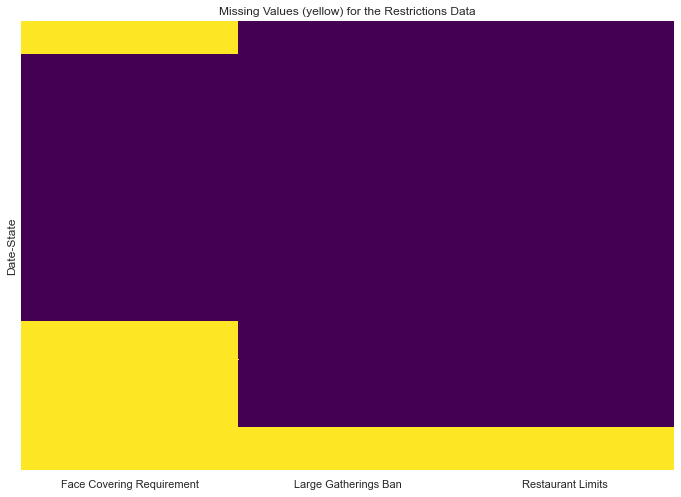

In [346]:
california_data = state_social_distancing_actions[state_social_distancing_actions.index.get_level_values('State').isin(['California'])]
ax = plt.axes()
sns.heatmap(california_data[["Face Covering Requirement", "Large Gatherings Ban", "Restaurant Limits"]].isnull(),yticklabels = False, cbar = False, cmap='viridis', ax=ax)
ax.set_title("Missing Values (yellow) for the Restrictions Data");


In [347]:
california_data.reset_index("State", inplace=True)
california_data = california_data[~california_data.index.duplicated(keep='first')]
# Fill inn missing dates with rows equal the previous date with data
days_idx = pd.date_range(start=california_data.index[0], end="2022-04-18", freq="D")
california_data = california_data.reindex(days_idx, method="pad")
# Update facemask data
california_data.loc[: "2020-06-17", "Face Covering Requirement"] = 0 # No
california_data.loc["2020-06-18" : "2021-06-14", "Face Covering Requirement"] = 1 # Yes
california_data.loc["2021-06-15" : "2021-12-14", "Face Covering Requirement"] = 0
california_data.loc["2021-12-15" : "2022-02-14", "Face Covering Requirement"] = 1
california_data.loc["2022-02-15" : , "Face Covering Requirement"] = 0
# Manually insert gathering limit for missing values
california_data.loc["2021-08-16 ":, "Large Gatherings Ban"] = "No Limit"
# Transform Large Gatherings Ban to a sevearity of the rules (1: no restrictions, 5: All gatherings prohibited)
california_data["Large Gatherings Ban"].replace({'All Gatherings Prohibited': 5, '>50 Prohibited': 4, 'Expanded Limit to 25 or Fewer': 3, '>25 Prohibited': 3, '>10 Prohibited': 2, 'No Limit': 1}, inplace=True)
# Set the missing restaurant values to open
california_data[california_data["Restaurant Limits"].isna()]["Restaurant Limits"] = "Open"

ohe_restaurant_limits = pd.get_dummies(california_data["Restaurant Limits"], prefix='Restaurant Limits', columns = 'Restaurant Limits')

selected_ca_restrictions = pd.concat([california_data[["Face Covering Requirement", "Large Gatherings Ban"]], ohe_restaurant_limits], axis=1)

#### Clean new restrictions data

In [348]:
restrictions_df = restrictions_df[restrictions_df.index.notnull()]
restrictions_df.replace("0", np.nan, inplace=True)

In [349]:
start_date = "2020-06-04"
end_date = "2022-03-28"

def add_missing_data(df, start, end):
  days_idx = pd.date_range(start=start, end=end, freq="D")
  days_with_missing_data = df.reindex(days_idx, fill_value=0)
  days_with_missing_data.index.names = ['date']
  df = days_with_missing_data.append(df)
  return df
  
single_restr = restrictions_df.loc[:, ["CLDAYCR", "OPNCLDCR", "STAYHOME", "END_STHM", "CLBSNS", "END_BSNS"]]
single_restrictions = pd.DataFrame({})

for i, j in zip(range(0, len(single_restr.columns), 2), range(1, len(single_restr.columns)+1, 2)):
  start_day = single_restr.columns[i]
  end_day = single_restr.columns[j]
  dates = single_restr.loc["California", [start_day, end_day]]
  
  if (isinstance(dates[0], str) and isinstance(dates[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates[0], dates[1]), 
                    single_restr.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates[0]) # now we will overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]
    single_restrictions = pd.concat([single_restrictions, fill_end], axis=1)
single_restrictions.fillna(0)
single_restrictions.rename(columns={"STAYHOME": "Stay at home order", "CLBSNS": "Closed other non-essential businesses", "CLDAYCR": "Closed day cares"}, inplace=True)


In [350]:
double_restrictions = restrictions_df.loc[:, ["CLREST", "ENDREST", "CLRST2", "ENDREST2", "CLGYM", "ENDGYM", "CLGYM2", "END_CLGYM2", "CLMOVIE", "END_MOV", "CLMV2", "END_CLMV2", "CLOSEBAR", "END_BRS", "BCLBAR2", "END_BRS2"]]
double_restrictions_conv = pd.DataFrame({})

for i in range(0, len(double_restrictions.columns), 4):
  start_day_first = double_restrictions.columns[i]
  end_day_first = double_restrictions.columns[i+1]
  start_day_second = double_restrictions.columns[i+2]
  end_day_second = double_restrictions.columns[i+3]
  dates_first = double_restrictions.loc["California", [start_day_first, end_day_first]]
  dates_second = double_restrictions.loc["California", [start_day_second, end_day_second]]
  
  if (isinstance(dates_first[0], str) and isinstance(dates_first[1], str)):
    new_df = pd.DataFrame({'date': pd.date_range(dates_first[0], dates_first[1]), 
                    double_restrictions.columns[i]: 1
                    }).set_index("date")
    fill_start = add_missing_data(new_df, start_date, dates_first[0]) # now we might overwrite the first and last date
    fill_end = add_missing_data(fill_start, dates_first[1], end_date)#.loc["2020-06-04" : "2022-03-28"]
    fill_end = fill_end[~fill_end.index.duplicated(keep='first')]

    if (isinstance(dates_second[0], str) and isinstance(dates_second[1], str)):
      fill_end.loc[dates_second[0]:dates_second[1], double_restrictions.columns[i]] = 1

    double_restrictions_conv = pd.concat([double_restrictions_conv, fill_end], axis=1)

double_restrictions_conv = double_restrictions_conv.fillna(0)
double_restrictions_conv.rename(columns={"CLREST": "Closed restaurants", "CLGYM": "Closed gym", "CLMOVIE": "Closed movie theaters", "CLOSEBAR": "Closed bars"}, inplace=True)




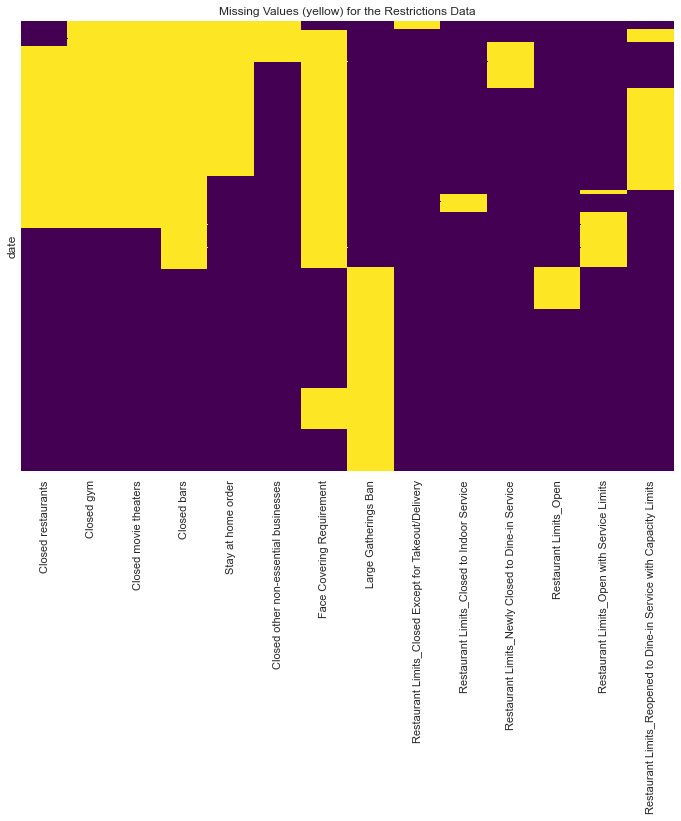

In [351]:
combined_restrictions = pd.concat([double_restrictions_conv, single_restrictions], axis=1)
combined_restrictions = combined_restrictions["2020-06-04" : "2022-03-28"]

merged_data = pd.concat([combined_restrictions, selected_ca_restrictions], axis=1)
ax2 = plt.axes()
sns.heatmap(merged_data==1, yticklabels = False, cbar = False, cmap='viridis',ax=ax2);
ax2.set_title("Missing Values (yellow) for the Restrictions Data");


#### Clean vaccination data


Each row of the vaccination data is a single date and contains information about distribution and administration of different vaccines. Much of this data incluting the total number of distributed vaccines are cumulative. The dataset do not start before the end of 2020 becuase we did not start to vaccinate people before then. To be able to merge this dataset with the others we therefore add all the dates from 2020-06-04 and set the number of vaccines distributed and administered for those days to 0. One problem with the data is that on the date 2022-01-27 the number of vaccines suddenly drops. However, this drop is not to large based on the whole dataset so we chose to not do anything with it since there is still a high number of administered vaccines.

In [352]:
days_idx = pd.date_range(start="2020-06-04", end="2020-12-13", freq="D")
days_with_missing_data = vaccination_df.reindex(days_idx, fill_value=0)
days_with_missing_data["Location"] = "CA"
days_with_missing_data.index.names = ['Date']
vaccination_df = days_with_missing_data.append(vaccination_df)

vaccination_df_administered = pd.DataFrame(vaccination_df["Administered"])
vaccination_df_administered.rename(columns={"Administered": "Total Vaccines Administered"}, inplace=True)
vaccination_df_administered

Total Vaccines Administered
Date                                   
2020-06-04                            0
2020-06-05                            0
2020-06-06                            0
2020-06-07                            0
2020-06-08                            0
...                                 ...
2022-04-16                     74123212
2022-04-17                     74232595
2022-04-18                     74270938
2022-04-19                     74289573
2022-04-20                     74358164

[686 rows x 1 columns]

#### Clean daily covid deaths

The rows in the daily covid deaths data contains the number of deaths in each state for each date. We chose to look at the "Deaths" column which had no missing values. This column is cumulative so we made new column from this to get the daily number of new deaths. What we then found out was that we had some rows with a negative number of dead people. This is probably becuase someone have gone in and corrected some errors in the data and what we did to reduce this error was to set all these negative values to 0.

In [353]:
covid_daily_reports = covid_daily_reports.reset_index()
states = ['California']
covid_daily_reports = covid_daily_reports[covid_daily_reports["State"].isin(states) == True]
covid_daily_reports.set_index(["Date"], inplace=True)

deaths_data = pd.DataFrame(covid_daily_reports["Deaths"])
deaths_data["Daily Deaths"] = deaths_data.diff(periods=1)
deaths_data = deaths_data[~deaths_data.index.duplicated(keep='first')] 
deaths_data.drop(["Deaths"], axis=1, inplace=True)

deaths_data[deaths_data["Daily Deaths"] < 0] = 0
deaths_data.head(5)


Daily Deaths
Date                    
2020-04-12           NaN
2020-04-13          62.0
2020-04-14          87.0
2020-04-15          92.0
2020-04-16          82.0

#### Clean infection rate data
This dataset contains information about the daily number of new cases of covid 19. We chose to take out the number of daily infections instead of the cumulative number of infections becuase it makes more sense if the model sees the current infections. Also there were 3 days where the number of infections were negative (between -3401 and -4803). To remove these invalid values we inserted 0 instead.

In [354]:
infected_df.index = infected_df.index.set_levels([pd.to_datetime(infected_df.index.levels[0]), infected_df.index.levels[1]])
infected_df.rename(columns={"new_case": "Daily New Infections"}, inplace=True)
infected_df_CA = infected_df[infected_df.index.get_level_values('state').isin(['CA'])]
infected_df_CA = infected_df_CA.reset_index()
infected_df_CA.set_index(["submission_date"], inplace=True)
infected_df_CA = infected_df_CA[["Daily New Infections"]].sort_index()
infected_df_CA[infected_df_CA["Daily New Infections"] < 0] = 0


#### Merge Restrictions, Vaccination, Infections and Deaths
Make sure all dataframes share the same date-time range

In [355]:
merged_data = pd.concat([selected_ca_restrictions["2020-06-04" : "2022-03-28"], vaccination_df_administered["2020-06-04" : "2022-03-28"], infected_df_CA["2020-06-04" : "2022-03-28"], deaths_data["2020-06-04" : ],combined_restrictions], axis=1)
merged_data.head(5)

Face Covering Requirement  Large Gatherings Ban  \
2020-06-04                         0                     5   
2020-06-05                         0                     5   
2020-06-06                         0                     5   
2020-06-07                         0                     5   
2020-06-08                         0                     5   

            Restaurant Limits_Closed Except for Takeout/Delivery  \
2020-06-04                                                  1      
2020-06-05                                                  1      
2020-06-06                                                  1      
2020-06-07                                                  1      
2020-06-08                                                  1      

            Restaurant Limits_Closed to Indoor Service  \
2020-06-04                                           0   
2020-06-05                                           0   
2020-06-06                                           0   
2020-06-07                                           0   
2020-06-08                                           0   

            Restaurant Limits_Newly Closed to Dine-in Service  \
2020-06-04                                                  0   
2020-06-05                                                  0   
2020-06-06                                                  0   
2020-06-07                                                  0   
2020-06-08                                                  0   

            Restaurant Limits_Open  \
2020-06-04                       0   
2020-06-05                       0   
2020-06-06                       0   
2020-06-07                       0   
2020-06-08                       0   

            Restaurant Limits_Open with Service Limits  \
2020-06-04                                           0   
2020-06-05                                           0   
2020-06-06                                           0   
2020-06-07                                           0   
2020-06-08                                           0   

            Restaurant Limits_Reopened to Dine-in Service with Capacity Limits  \
2020-06-04                                                  0                    
2020-06-05                                                  0                    
2020-06-06                                                  0                    
2020-06-07                                                  0                    
2020-06-08                                                  0                    

            Total Vaccines Administered  Daily New Infections  Daily Deaths  \
2020-06-04                            0                  2120          79.0   
2020-06-05                            0                  3094          69.0   
2020-06-06                            0                  3115          71.0   
2020-06-07                            0                  2796          26.0   
2020-06-08                            0                  2507          28.0   

            Closed restaurants  Closed gym  Closed movie theaters  \
2020-06-04                   0         1.0                    1.0   
2020-06-05                   0         1.0                    1.0   
2020-06-06                   0         1.0                    1.0   
2020-06-07                   0         1.0                    1.0   
2020-06-08                   0         1.0                    1.0   

            Closed bars  Stay at home order  \
2020-06-04            1                 1.0   
2020-06-05            1                 1.0   
2020-06-06            1                 1.0   
2020-06-07            1                 1.0   
2020-06-08            1                 1.0   

            Closed other non-essential businesses  
2020-06-04                                    1.0  
2020-06-05                                    1.0  
2020-06-06                                    1.0  
2020-06-07                           

#### Clean Deaths by Sex, Age & State

The rows in the Deaths by Sex, Age & State data contains deaths by age and sex grouped on month, year and total. Becuase we are interested in the least time intervel we only look at deaths per month. In addition we have to filter on the states because there were some locations like "USA" that weren't states.

In [356]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
df_sex_age = df_sex_age[df_sex_age["State"].isin(states) == True]
df_sex_age = df_sex_age[df_sex_age["Group"] == 'By Month'] 

df_sex_age["End Date"] = pd.to_datetime(df_sex_age["End Date"])


#### Clean condition data

The rows in the Conditions data contains deaths with the contributing/underlying condition grouped on month, year and total. Becuase we are interested in the least time intervel we only look at deaths per month. In addition we have to filter on the states because there were some locations like "USA" that weren't states.

In [357]:
df_condition = df_condition[df_condition["State"].isin(states) == True]
df_condition = df_condition[df_condition["Group"] == 'By Month'] 

In [358]:
df_anx_dep.head()

Indicator              Group          State  \
0  Symptoms of Depressive Disorder  National Estimate  United States   
1  Symptoms of Depressive Disorder             By Age  United States   
2  Symptoms of Depressive Disorder             By Age  United States   
3  Symptoms of Depressive Disorder             By Age  United States   
4  Symptoms of Depressive Disorder             By Age  United States   

        Subgroup Phase  Time Period     Time Period Label  \
0  United States     1            1  Apr 23 - May 5, 2020   
1  18 - 29 years     1            1  Apr 23 - May 5, 2020   
2  30 - 39 years     1            1  Apr 23 - May 5, 2020   
3  40 - 49 years     1            1  Apr 23 - May 5, 2020   
4  50 - 59 years     1            1  Apr 23 - May 5, 2020   

  Time Period Start Date Time Period End Date  Value  Low CI  High CI  \
0             04/23/2020           05/05/2020   23.5    22.7     24.3   
1             04/23/2020           05/05/2020   32.7    30.2     35.2   
2             04/23/2020           05/05/2020   25.7    24.1     27.3   
3             04/23/2020           05/05/2020   24.8    23.3     26.2   
4             04/23/2020           05/05/2020   23.2    21.5     25.0   

  Confidence Interval Quartile Range  
0         22.7 - 24.3            NaN  
1         30.2 - 35.2            NaN  
2         24.1 - 27.3            NaN  
3         23.3 - 26.2            NaN  
4         21.5 - 25.0            NaN

#### Clean anxiety data

Each rows in this dataset contains information about respondents from different age groups and their mental health value. This dataset has aggregated data grouped by _Education_, _By Age_,_State_ etc. Since we are analyzing mental health data together with restrictions particularly in California, we have to extract data only considering this state. The way this data is organizied causes us to lose important information such as age, sex and education. <br>

The restriction data contains change in restriction for every day. The mental health data is aggregated over longer periods varying from 7-25 days. To be able to merge the datasets together, we group all the restriction data in the mental health data's timespans and take the average. Afterwards we concenate the rows, such that each row contain information about the mental health value in a time period together with the average restricitons in the same period. <br>

For each time span the mental health data consists of three different values: _Symptoms of Depressive Disorder, _Symptoms of Anxiety Disorder_ or both of them. When evaluating mental health we concluded it was beneficial to aggregate these values to one. This value will be a measurement of the overall mental health rating in this time span. <br>
Afterwards we dropped a column, which also contains information regarding the date. We also dropped information about the confidence interval of the mental health value - because it will leak information to the mental health value which we are trying to predict. 

In [359]:
df_anx_dep2 = df_anx_dep[df_anx_dep['State']=='California']

merged_no_index = merged_data.copy().reset_index()
merged_no_index['index'] = pd.to_datetime(merged_no_index['index'])
restriction_mental = pd.DataFrame()
for index, row in df_anx_dep2.iterrows():
    first_date = pd.to_datetime(row['Time Period Start Date'])
    last_date = pd.to_datetime(row['Time Period End Date'])
    
    interval_rows = merged_no_index[(merged_no_index['index']>= first_date) & (merged_no_index['index']<= last_date)]
    interval_rows = pd.DataFrame(interval_rows.mean()).T
    row = pd.DataFrame(row).T
    interval_rows.rename(index={0:row.index[0]},inplace=True) 
    result = pd.concat([row,interval_rows], axis=1,join='inner')
    restriction_mental = pd.concat([restriction_mental,result],axis = 0)
    
restriction_mental= restriction_mental.fillna(0)
restriction_mental.rename({"Value": "Mental Health Score"}, axis=1, inplace=True)

In [360]:
restriction_mental['Mental Health Score'] = restriction_mental['Mental Health Score'].astype(float)
restriction_mental = restriction_mental.groupby('Time Period End Date').mean()
restriction_mental.index = pd.to_datetime(restriction_mental.index)
restriction_mental = restriction_mental.sort_index()
restriction_mental = restriction_mental.drop(["Time Period",'Low CI','High CI'], axis=1)
restriction_mental.head()


Mental Health Score  Face Covering Requirement  \
Time Period End Date                                                   
2020-05-05                      31.200000                        0.0   
2020-05-12                      29.533333                        0.0   
2020-05-19                      33.266667                        0.0   
2020-05-26                      31.166667                        0.0   
2020-06-02                      33.100000                        0.0   

                      Large Gatherings Ban  \
Time Period End Date                         
2020-05-05                             0.0   
2020-05-12                             0.0   
2020-05-19                             0.0   
2020-05-26                             0.0   
2020-06-02                             0.0   

                      Restaurant Limits_Closed Except for Takeout/Delivery  \
Time Period End Date                                                         
2020-05-05                                                          0.0      
2020-05-12                                                          0.0      
2020-05-19                                                          0.0      
2020-05-26                                                          0.0      
2020-06-02                                                          0.0      

                      Restaurant Limits_Closed to Indoor Service  \
Time Period End Date                                               
2020-05-05                                                   0.0   
2020-05-12                                                   0.0   
2020-05-19                                                   0.0   
2020-05-26                                                   0.0   
2020-06-02                                                   0.0   

                      Restaurant Limits_Newly Closed to Dine-in Service  \
Time Period End Date                                                      
2020-05-05                                                          0.0   
2020-05-12                                                          0.0   
2020-05-19                                                          0.0   
2020-05-26                                                          0.0   
2020-06-02                                                          0.0   

                      Restaurant Limits_Open  \
Time Period End Date                           
2020-05-05                               0.0   
2020-05-12                               0.0   
2020-05-19                               0.0   
2020-05-26                               0.0   
2020-06-02                               0.0   

                      Restaurant Limits_Open with Service Limits  \
Time Period End Date                                               
2020-05-05                                                   0.0   
2020-05-12                                                   0.0   
2020-05-19                                                   0.0   
2020-05-26                                                   0.0   
2020-06-02                                                   0.0   

                      Restaurant Limits_Reopened to Dine-in Service with Capacity Limits  \
Time Period End Date                                                                       
2020-05-05                                                          0.0                    
2020-05-12                                                          0.0                    
2020-05-19                                                          0.0                    
2020-05-26                                                          0.0                    
2020-06-02                                                          0.0                    

                      Total Vaccines Administered  Daily New Infections  \
Time Period End Date                                                      
2020-05-05                         

## Exploratory Data Analysis

#### EDA death by sex, age & state

#### Correlation

To get a better understanding of the restrictions dataset, we decided to make plots describing the datasets features correlation. Since we have many features, we decided to drop someone in this plot to make the plot more understandable. We remove some of the restaurant-features since they show the same thing. We also have to cast the Face Covering Requirement to an integer in order to calculate the correlations correctly.
The correlation plot shows which features are related to eachother. 
We also made a sorted list of the most correlation featuers with the feature _Daily Deaths_.


Daily Death's most correlated features: 

Daily Deaths                                                          1.000000
Closed restaurants                                                    0.371934
Closed movie theaters                                                 0.317838
Closed gym                                                            0.317838
Restaurant Limits_Reopened to Dine-in Service with Capacity Limits    0.275578
Face Covering Requirement                                             0.238481
Total Vaccines Administered                                           0.224276
Restaurant Limits_Open                                                0.219338
Closed bars                                                           0.217890
Restaurant Limits_Closed to Indoor Service                            0.203069
Daily New Infections                                                  0.193191
Large Gatherings Ban                                                  0.113682
Closed oth

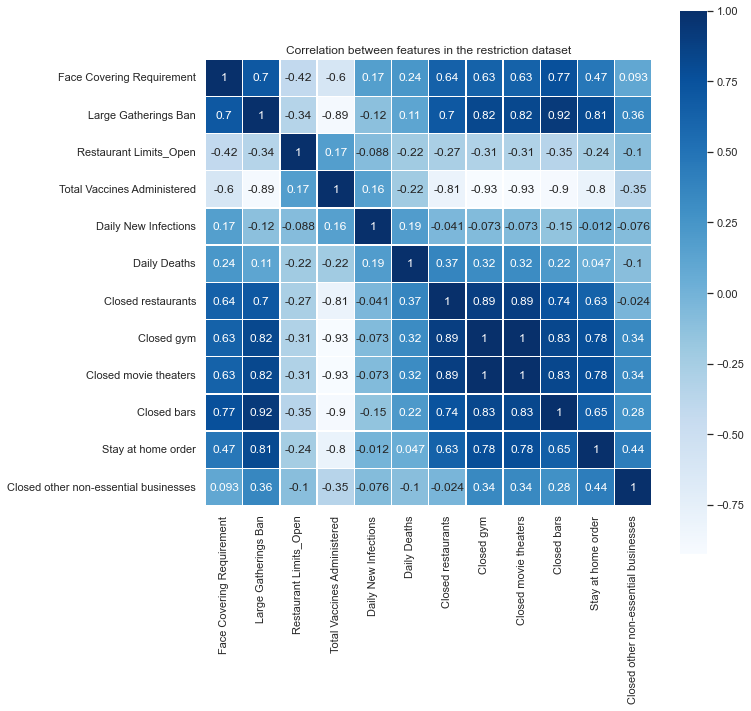

In [361]:
merged_data['Face Covering Requirement'] = merged_data['Face Covering Requirement'].astype(int)
merged_data_fixed = merged_data.drop(columns=['Restaurant Limits_Reopened to Dine-in Service with Capacity Limits','Restaurant Limits_Closed to Indoor Service','Restaurant Limits_Open with Service Limits','Restaurant Limits_Closed Except for Takeout/Delivery','Restaurant Limits_Newly Closed to Dine-in Service'])  
f, ax = plt.subplots(figsize=(10,10))
plt.title('Correlation between features in the restriction dataset')
sns.heatmap(merged_data_fixed.corr(),linewidth=0.5,cmap="Blues", square=True,annot=True)

correlation = merged_data.corr()
print("Daily Death's most correlated features: \n")
print(abs(correlation['Daily Deaths']).sort_values(ascending = False), "\n")

To get a better overview of the most important features, we made a correlation plot directly with Daily Deaths.
We notice that it is usually more deaths when there are stricter restrictions. This makes sense considering why the government implements restrictions.

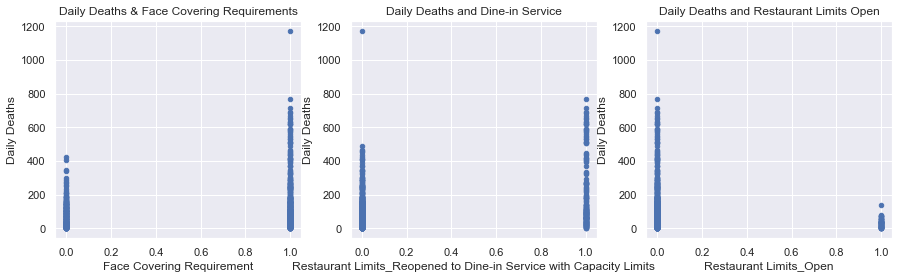

In [362]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3 ,figsize=(15,4))
var = 'Face Covering Requirement' 
ax1.set_title('Daily Deaths & Face Covering Requirements')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths', ax=ax1);
var = 'Restaurant Limits_Reopened to Dine-in Service with Capacity Limits'
ax2.set_title('Daily Deaths and Dine-in Service')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths',ax=ax2);
var = 'Restaurant Limits_Open'
ax3.set_title('Daily Deaths and Restaurant Limits Open')
data = pd.concat([merged_data['Daily Deaths'], merged_data[var]], axis=1)
data.plot.scatter(x=var, y='Daily Deaths',ax=ax3);

We did the same analysis on the mental health data merged with restrictions. 
The value that determines how the average mental health is in California is noticeable correlated with _Total Vaccines Administered_, _Closed movie theaters_, _closed gym_ and _closed restaurants_. <br>


In [363]:
correlation = restriction_mental.corr()
print("Mental Health most correlated features: \n")
print(abs(correlation['Mental Health Score']).sort_values(ascending = False), "\n")


Mental Health most correlated features: 

Mental Health Score                                                   1.000000
Closed movie theaters                                                 0.848291
Closed gym                                                            0.848291
Total Vaccines Administered                                           0.812159
Closed restaurants                                                    0.768499
Stay at home order                                                    0.707384
Closed bars                                                           0.677768
Restaurant Limits_Reopened to Dine-in Service with Capacity Limits    0.646949
Large Gatherings Ban                                                  0.635872
Face Covering Requirement                                             0.545250
Daily Deaths                                                          0.434726
Restaurant Limits_Open                                                0.392629
Restaurant

#### Outliers

To get a better overview of potential outliers in the different datasets, we make boxplots.
Many outliers are visible in these pots. Outstanding covid 19 deaths are very interesting for our analysis to get a better understanding of what is causing 'spikes' in the number of deaths.

<AxesSubplot:title={'center':'Total Deaths in Condition dataset'}>

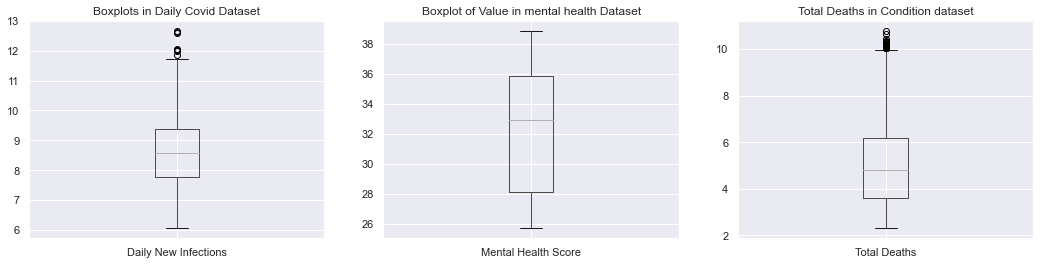

In [364]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,4))
#log-transform values to better visualizations
merged_data_box = merged_data.copy()
merged_data_box['Daily New Infections'] = np.log(merged_data_box['Daily New Infections'])
df_sex_age_box = df_sex_age.copy()
df_sex_age_box['Total Deaths'] = np.log(df_sex_age_box['Total Deaths'])

ax1.title.set_text('Boxplots in Daily Covid Dataset')
ax2.title.set_text('Boxplot of Value in mental health Dataset')
ax3.title.set_text('Total Deaths in Condition dataset')
merged_data_box.boxplot(column=['Daily New Infections'],ax=ax1)
restriction_mental.boxplot(column=['Mental Health Score'],ax=ax2)
df_sex_age_box.boxplot(column=['Total Deaths'],ax=ax3)

## Feature Engineering

In [365]:
merged_data["Total Vaccines Administered"] = np.log(merged_data["Total Vaccines Administered"] + 1).fillna(0)
merged_data.head()

Face Covering Requirement  Large Gatherings Ban  \
2020-06-04                          0                     5   
2020-06-05                          0                     5   
2020-06-06                          0                     5   
2020-06-07                          0                     5   
2020-06-08                          0                     5   

            Restaurant Limits_Closed Except for Takeout/Delivery  \
2020-06-04                                                  1      
2020-06-05                                                  1      
2020-06-06                                                  1      
2020-06-07                                                  1      
2020-06-08                                                  1      

            Restaurant Limits_Closed to Indoor Service  \
2020-06-04                                           0   
2020-06-05                                           0   
2020-06-06                                           0   
2020-06-07                                           0   
2020-06-08                                           0   

            Restaurant Limits_Newly Closed to Dine-in Service  \
2020-06-04                                                  0   
2020-06-05                                                  0   
2020-06-06                                                  0   
2020-06-07                                                  0   
2020-06-08                                                  0   

            Restaurant Limits_Open  \
2020-06-04                       0   
2020-06-05                       0   
2020-06-06                       0   
2020-06-07                       0   
2020-06-08                       0   

            Restaurant Limits_Open with Service Limits  \
2020-06-04                                           0   
2020-06-05                                           0   
2020-06-06                                           0   
2020-06-07                                           0   
2020-06-08                                           0   

            Restaurant Limits_Reopened to Dine-in Service with Capacity Limits  \
2020-06-04                                                  0                    
2020-06-05                                                  0                    
2020-06-06                                                  0                    
2020-06-07                                                  0                    
2020-06-08                                                  0                    

            Total Vaccines Administered  Daily New Infections  Daily Deaths  \
2020-06-04                          0.0                  2120          79.0   
2020-06-05                          0.0                  3094          69.0   
2020-06-06                          0.0                  3115          71.0   
2020-06-07                          0.0                  2796          26.0   
2020-06-08                          0.0                  2507          28.0   

            Closed restaurants  Closed gym  Closed movie theaters  \
2020-06-04                   0         1.0                    1.0   
2020-06-05                   0         1.0                    1.0   
2020-06-06                   0         1.0                    1.0   
2020-06-07                   0         1.0                    1.0   
2020-06-08                   0         1.0                    1.0   

            Closed bars  Stay at home order  \
2020-06-04            1                 1.0   
2020-06-05            1                 1.0   
2020-06-06            1                 1.0   
2020-06-07            1                 1.0   
2020-06-08            1                 1.0   

            Closed other non-essential businesses  
2020-06-04                                    1.0  
2020-06-05                                    1.0  
2020-06-06                                    1.0  
2020-06-07                      

### Data Modeling and Inferences

1) Plots of Total Deaths <br>
2) Plots of Covid 19 Deaths and Mental Health based on Restrictions <br>
3) Prediciton of Death Rates based on restrictions <br>
4) Prediciton of Mental Health based on restrictions and Death Rates <br>

#### Deaths in California by Sex, Age & Condition

We group the data by each date and each age group and aggregate the data by the sum. This way we can count the number of Covid Deaths across many states. <br>
We also plot the number of deaths by age in just California. We decided to remove 'all ages' in the plot in order to see the results more clearly. Notice how the number of deaths in California is very similar to the plot over Total Deaths in the United States. <br>

We also made a plot showing the number of deaths grouped by gender. One can see that more men tend to die compared to women. <br>

In the last plot we can see how the number of deaths varies in terms of other health conditions. One can notice how Respitory diseases and Covid-19 cases has the highest number of correlated deaths.

In [366]:
init_notebook_mode()

fig = go.Figure()

df_sex_age_grouped = pd.DataFrame(df_sex_age.groupby(['End Date','Age Group'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

    
for name, frame in df_sex_age_grouped.groupby('Age Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in the USA by year and age',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)



In [367]:
fig = go.Figure()
df_sex_age_cali = df_sex_age[df_sex_age['State']=='California']
df_sex_age_grouped = pd.DataFrame(df_sex_age_cali.groupby(['End Date','Age Group'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

df_sex_age_grouped = df_sex_age_grouped[df_sex_age_grouped['Age Group']!= 'All Ages']
for name, frame in df_sex_age_grouped.groupby('Age Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in California by year and age',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

In [368]:
fig = go.Figure()
df_sex_age_cali = df_sex_age[df_sex_age['State']=='California']
df_sex_age_grouped = pd.DataFrame(df_sex_age_cali.groupby(['End Date','Sex'])["COVID-19 Deaths"].sum())
df_sex_age_grouped = df_sex_age_grouped.reset_index()

for name, frame in df_sex_age_grouped.groupby('Sex'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')

fig.update_layout(title='Total Deaths in California by year and Sex',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

In [369]:
init_notebook_mode()

fig = go.Figure()
grouped_df_condition = pd.DataFrame(df_condition.groupby(['End Date','Condition Group'])["COVID-19 Deaths"].sum())
grouped_df_condition = grouped_df_condition.reset_index()
    
for name, frame in grouped_df_condition.groupby('Condition Group'):
    fig.add_scatter(x=frame['End Date'], y=frame['COVID-19 Deaths'], name=name, mode='lines')
fig.update_layout(title='Total Deaths in California by year and Condition',xaxis={'title':'Date'},yaxis={'title':'Number of Deaths'})
iplot(fig)

#### Percentage with symptoms of anxiety and/or depression

Here we group the mental health data by age and look at the percentage of people with "Symptoms of Anxiety Disorder or Depressive Disorder". Then we plot this distribution over time. 

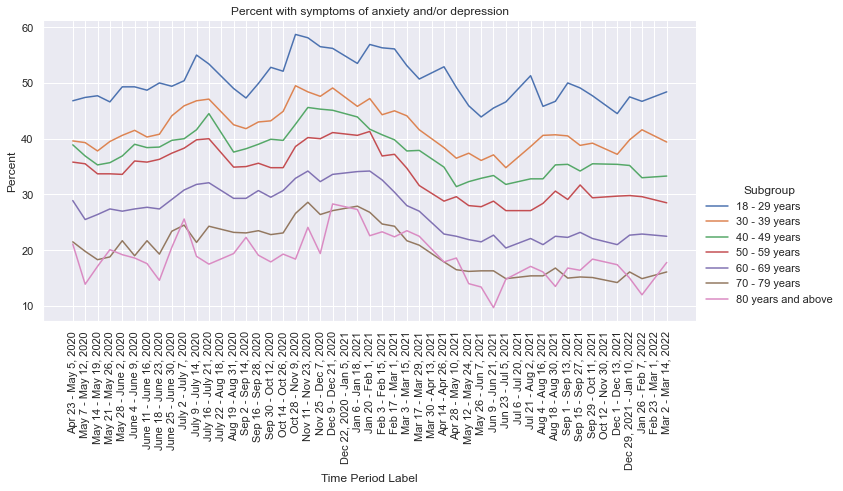

In [370]:
df_mentalhealth = df_anx_dep.copy()
df_mentalhealth_byAge = df_mentalhealth.loc[df_mentalhealth["Group"]=="By Age"]
df_anxietydepression_byAge = df_mentalhealth_byAge.loc[df_mentalhealth_byAge["Indicator"]=='Symptoms of Anxiety Disorder or Depressive Disorder'] 

sns.relplot(
    data=df_anxietydepression_byAge, x="Time Period Label", y="Value",
    hue="Subgroup", kind="line", aspect=2
)

plt.ylabel("Percent")
plt.title("Percent with symptoms of anxiety and/or depression")
plt.xticks(rotation = 'vertical');

#### Restrictions and Total Deaths

In the following plots we try to get an overview over how certain restrictions have affected the number of deaths and mental health. In order to make these plots we have to construct some new features that captures changes in some restrictions. We decided to do this with _Face Covering Requirement_, _Restaurant Limits Open_ and _Large Gathering Bans_. These are important restrictions which we think will have the largest impact.

We start off by plotting the number of deaths together with an overview over when restrictions were inferred or removed. In the last plot we show how _Large Gathering Bans_ varies over time, together with a plot of mental health value. In this plot, the stronger the color (from green to red) the stricter the restriction is.

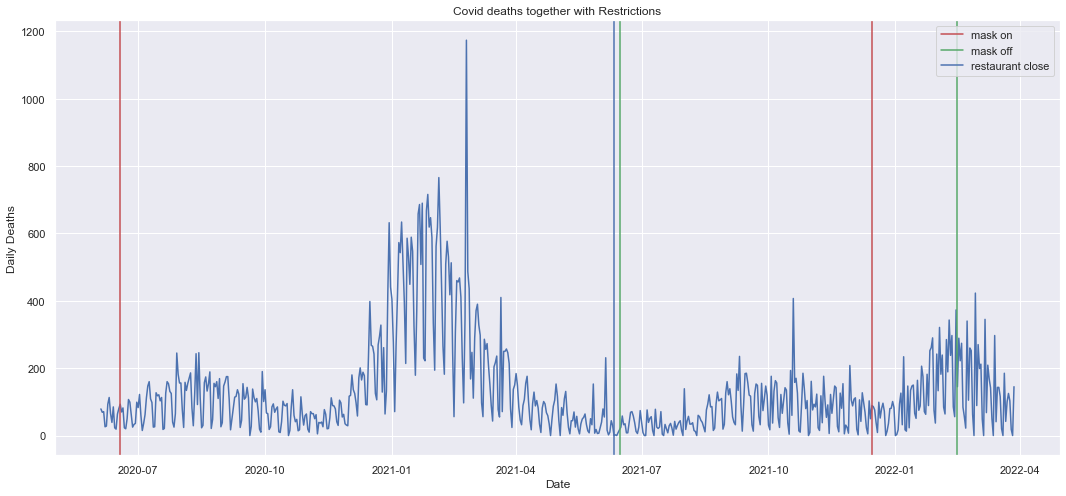

In [371]:

merged_data_2 = merged_data.copy() 
merged_data_2['Face Change'] = merged_data_2['Face Covering Requirement'].diff()
merged_data_2['Restaurant Change'] = merged_data_2['Restaurant Limits_Open'].diff()

mask_on = merged_data_2[(merged_data_2['Face Change']==1) | (merged_data_2['Face Change']==-1) ]
restaurant_on = merged_data_2[(merged_data_2['Restaurant Change']==1) | (merged_data_2['Restaurant Change']==-1) ]
plt.figure(figsize = (18,8))
merged_data_2.reset_index(inplace=True)
sns.lineplot(x = 'index', y = 'Daily Deaths',data = merged_data_2)
my_label = "mask on"
my_label2 = "mask off"

for index, row in mask_on.iterrows():
    if row['Face Change'] ==1:
        plt.axvline(x = index, color = 'r',
                label = my_label)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'g',
                label = my_label2)
        my_label2 = '_nolegend_'
        
my_label3 = "restaurant close"
my_label4 = "restarant open"
days = datetime.timedelta(3)
for index, row in restaurant_on.iterrows():
    if row['Restaurant Change'] ==1:
        plt.axvline(x = index-days, color = 'b',
                label = my_label3)
        my_label3 = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'y',
                label = my_label4)
        my_label4 = '_nolegend_'
        
        
plt.legend()
plt.title('Covid deaths together with Restrictions')
plt.xlabel('Date');

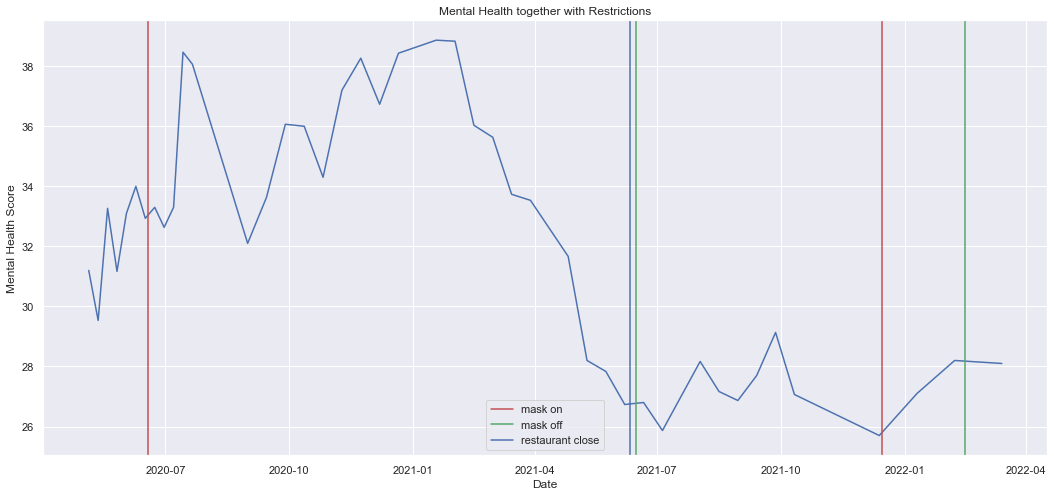

In [372]:
restriction_mental_2 = restriction_mental.copy() 

plt.figure(figsize = (18,8))
restriction_mental_2.reset_index(inplace=True)

sns.lineplot(x = 'Time Period End Date', y = 'Mental Health Score',data = restriction_mental_2)

my_label = "mask on"
my_label2 = "mask off"

for index, row in mask_on.iterrows():
    if row['Face Change'] ==1:
        plt.axvline(x = index, color = 'r',
                label = my_label)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'g',
                label = my_label2)
        my_label2 = '_nolegend_'

my_label3 = "restaurant close"
my_label4 = "restarant open"

for index, row in restaurant_on.iterrows():
    if row['Restaurant Change'] ==1:
        plt.axvline(x = index-days, color = 'b',
                label = my_label3)
        my_label = '_nolegend_'
    else :
        plt.axvline(x = index, color = 'y',
                label = my_label)
        my_label2 = '_nolegend_'
        
plt.legend()
plt.title('Mental Health together with Restrictions')
plt.xlabel('Date');


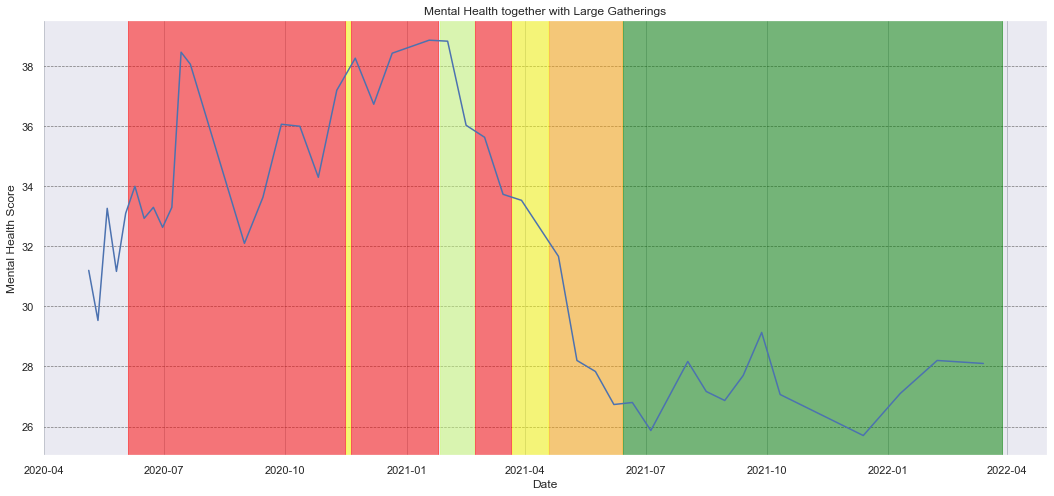

In [373]:
current_val = 5
start_day = '2020-06-04'
last_date = None
dict_dates = {}

for index, row in merged_data.iterrows():
    if current_val != row['Large Gatherings Ban']:
        dict_dates[start_day] = [last_date,current_val]
        current_val = row['Large Gatherings Ban']
        start_day = index
    else:
        last_date = index

dict_dates[start_day] = [last_date,current_val]
        
color_dict = {5: 'red',4:'orange',3:'yellow',2:'#CAFF70',1:'green',0:'blue'}
plt.figure(figsize = (18,8))
ax =sns.lineplot(x = 'Time Period End Date', y = 'Mental Health Score',data = restriction_mental_2)
for key in dict_dates:
    color = color_dict[dict_dates[key][1]]
    ax.axvspan(key,dict_dates[key][0], color=color, alpha=0.5)


ax.grid(color='#79818f', alpha=0.6, linestyle='solid', linewidth=0.7, axis='x')
ax.grid(color='#2B2A27', alpha=0.6, linestyle='dashed', linewidth=0.7, axis='y')


plt.title('Mental Health together with Large Gatherings')
plt.xlabel('Date');

#### Prediction of Death Rates
To get a better understanding of the data, the impact of different features and if we are able to make a good model for future covid-19 we start off by making a normal linear model with an intercept term. We split the data into a training and test set. We decided not to make this shuffled, since we want to be able to predict the future, and not the number of covid cases on a random date. 

In [374]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    merged_data.drop('Daily Deaths', axis=1), 
    merged_data['Daily Deaths'], 
    test_size=0.3, shuffle=False)

X_train_.shape, X_test_.shape


((464, 16), (199, 16))

Here we can see the traning and test data after the split.

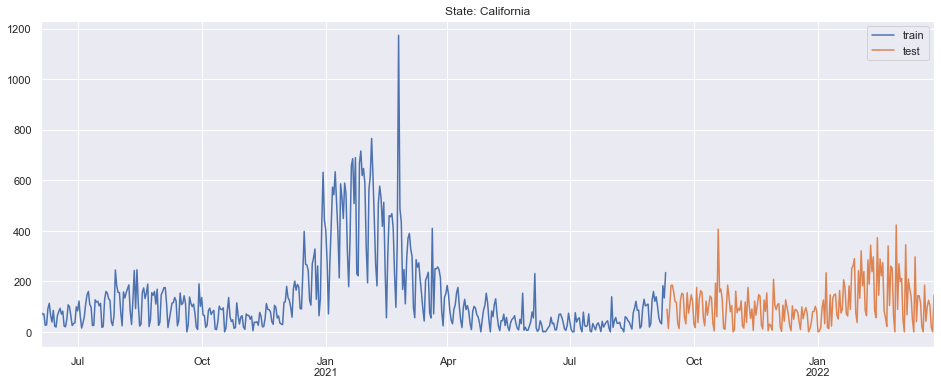

In [375]:
y_train_.plot(label='train', figsize=(16,6))
y_test_.plot(label='test')
plt.title("State: {}".format("California")); plt.legend();

This models RMSE: 101.28188514682984


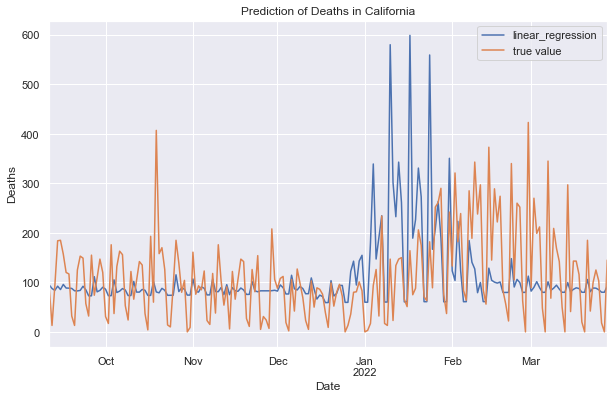

In [376]:
model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train_, y_train_)

pred_lr = pd.Series(model.predict(X_test_), index = y_test_.index)
pred_lr.plot(label='linear_regression')
y_test_.plot(label='true value', figsize=(10,6));
plt.title("Prediction of Deaths in California"); plt.legend();
plt.xlabel('Date')
plt.ylabel('Deaths')
print("This models RMSE:", mean_squared_error(y_test_, pred_lr,squared=False))

#### Model improvement

The normal Linear Model performed decent, but we think we can make even better predictions.
Therefore, we tried other linear models such as Ridge and Lasso regressor. These models include a regularization parameter which penalizes features with large weigths. This can help reduce overfitting. We tried several different values for the alpha parameter (which decides how much is penalized), but did not get better predictions than the normal linear regressor. We also try to make a prediction with the average of both Lasso and Ridge, which not improved prediction either. The reason for this is that both models are very similar, and in order to improve model prediction by averaging - we should average models with low RMSE and low correlation with eachother, so they together can capture the most important.

In [377]:

ridge = Ridge(alpha=0.1)
ridge.fit(X_train_, y_train_)
pred_ridge= pd.Series(ridge.predict(X_test_), index = y_test_.index)
print("Ridge model RMSE:", mean_squared_error(y_test_, pred_ridge,squared=False))

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_, y_train_)
pred_lasso= pd.Series(lasso.predict(X_test_), index = y_test_.index)
print("Lasso model RMSE:", mean_squared_error(y_test_, pred_lasso,squared=False))
average_pred = (pred_lr+pred_lasso+pred_ridge)/3
print("Average RMSE:", mean_squared_error(y_test_, average_pred,squared=False))


Ridge model RMSE: 106.40296603294486
Lasso model RMSE: 106.93123397532698
Average RMSE: 104.57645931603264


## More advanced regressors

We decieded to try som other strong regressor models. Both of these algorithms used Gradient Boosted Machines, which gives a prediction model in the form of an ensemble of weak prediction models with decision trees. <br>
As we can see on the RMSE, the XGB-model performed worse than the linear regressor, but the Light GBM performed very well.

In [378]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train_, y_train_)
xgb_pred_hat = pd.Series(xgb_model.predict(X_test_), index = y_test_.index)
print("Average RMSE for XGBRegressor:", mean_squared_error(y_test_, xgb_pred_hat,squared=False))

Average RMSE for XGBRegressor: 159.29637738938754


In [379]:
lgb_model = lgb.LGBMRegressor()

lgb_model.fit(X_train_, y_train_)
lgb_pred_hat = lgb_model.predict(X_test_)
print("Average RMSE for LightBM regressor:", mean_squared_error(y_test_, lgb_pred_hat,squared=False))

Average RMSE for LightBM regressor: 84.468779680416


### Hyperparameter tuning

The models performed decent. We try to improve performance even further by tuning the parameters.

In [380]:
n_estimators = [500, 550, 600, 650]
max_depth = [4,5,7,9,10]
booster = ['gbtree']
learning_rate = [0.2,0.4,0.5]
min_child_weight = [0.5,2,3,4]
base_score = [0.5]
subsample = [0.5, 0.6,1.2,1.5]
tree_method='gpu_hist'
regressor = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'booster': booster,
    'base_score': base_score,
    'subsample': subsample
}
random_cv = RandomizedSearchCV(estimator = regressor, 
                              param_distributions = hyperparameter_grid,
                              cv=5,
                              n_iter = 50,
                              scoring = 'neg_mean_squared_error',
                              n_jobs = 4,
                              verbose = 0,
                              return_train_score = True,
                              random_state = 42)
random_cv.fit(X_train_, y_train_)
xgb_params = random_cv.best_params_
xgb_model = xgb.XGBRegressor(**xgb_params)

In [381]:
print(xgb_params)

{'subsample': 0.6, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.2, 'booster': 'gbtree', 'base_score': 0.5}


In [382]:
xgb_model.fit(X_train_, y_train_)
xgb_pred_hat_2 = xgb_model.predict(X_test_)
print("Average RMSE for XGBRegressor with tuned parameters:", mean_squared_error(y_test_, xgb_pred_hat_2,squared=False))

Average RMSE for XGBRegressor with tuned parameters: 150.0956720434051


In [383]:
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,25],'max_depth':[1,3,10,20],
             'learning_rate':[0.05,0.2,0.3],'reg_alpha':[0,0.01,0.03,0.1]}
lgb_model2 = lgb.LGBMRegressor()
clf=RandomizedSearchCV(lgb_model2,parameters,n_iter=100)
clf.fit(X=X_train_, y=y_train_)
print(clf.best_params_)

{'reg_alpha': 0, 'num_leaves': 20, 'min_child_samples': 10, 'max_depth': 1, 'learning_rate': 0.3}


In [384]:
lgb_pred_hat_2 = clf.predict(X_test_)
print("Average RMSE for LGBMRegressor with tuned parameters:", mean_squared_error(y_test_, lgb_pred_hat_2,squared=False))



Average RMSE for LGBMRegressor with tuned parameters: 84.36713131625895


After tuning the different hyperparameters, we could not improve the importance any further compared to the model that used the default parameters.

We therefore decided to use the LightGBM with the default parameters as our final prediction.

Text(0, 0.5, 'Deaths')

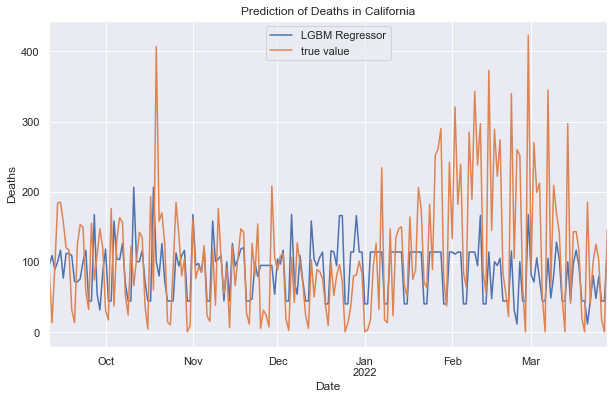

In [385]:
pd.Series(lgb_pred_hat, index = y_test_.index).plot(label='LGBM Regressor')
y_test_.plot(label='true value', figsize=(10,6));
plt.title("Prediction of Deaths in California"); plt.legend();
plt.xlabel('Date')
plt.ylabel('Deaths')

#### Feature Importance

Both of the models have a function included called plot_importance, which shows which features was the most important for prediction the number of deaths.

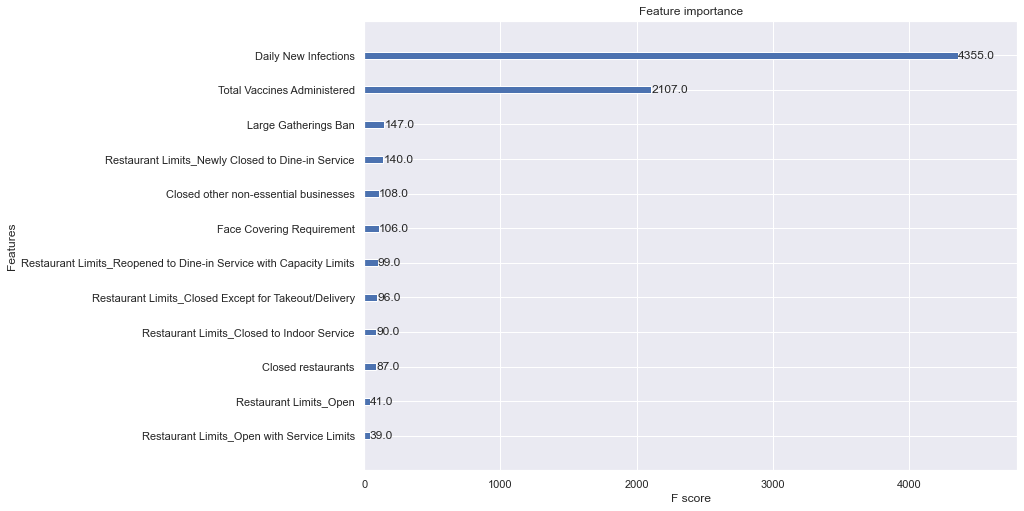

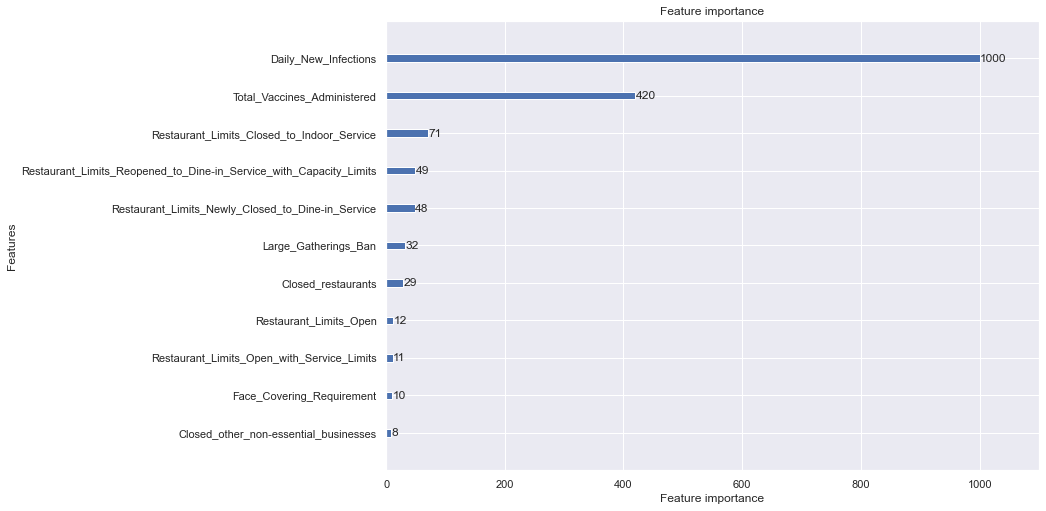

In [386]:
xgb.plot_importance(xgb_model)
lgb.plot_importance(lgb_model);

#### Prophet
Prophet is prediction algorithm created by Facebook. It uses time-series, seasonality and trends to give a prediction of the future.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.04639
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1208.81      0.154093       792.965           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1215.91    0.00445681       170.897   5.573e-05       0.001      182  LS failed, Hessian reset 
     164       1218.45    0.00129003       170.675    1.13e-05       0.001      267  LS failed, Hessian reset 
     199       1218.71    1.7405e-06       62.1193      0.2686      0.7539      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1218.71   2.09058e-07        74.728           1           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Text(0.5, 1.0, 'Prediction of future with Prophet')

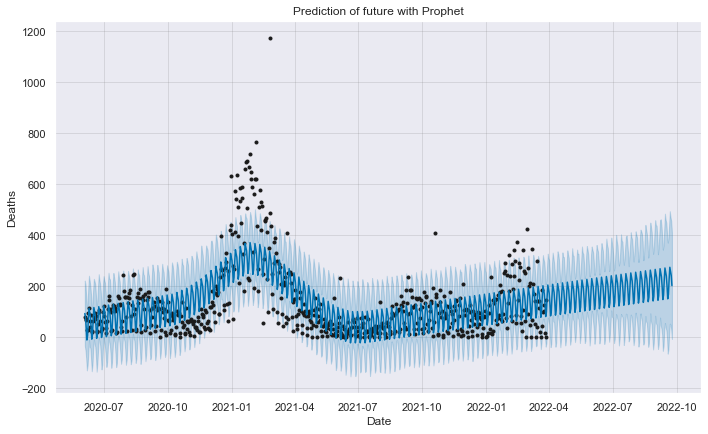

In [387]:
model = Prophet()

hans_data = merged_data.copy().reset_index()
hans_data = hans_data.rename(columns={"index": "ds", "Daily Deaths": "y"})
model.fit(hans_data)
future = model.make_future_dataframe(periods=180)
future.tail()
forecast = model.predict(future)

fig1 = model.plot(forecast)
axes = fig1.get_axes()
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Deaths')
axes[0].set_title('Prediction of future with Prophet')


#### Prediction of Mental Health
We also tried to make a model in order to predict the value of mental health with the restriction data.
As we can see on the plot below, our prediciton is not very accurate. This shows that using the restriction we found is not sufficient for evaluating mental health.

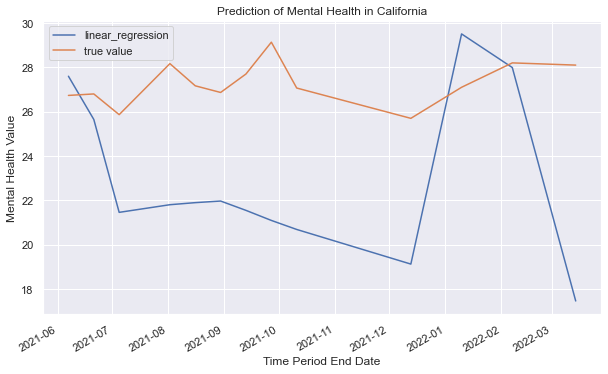

In [388]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    restriction_mental.drop('Mental Health Score', axis=1), 
    restriction_mental['Mental Health Score'], 
    test_size=0.3, shuffle=False)

model = lm.LinearRegression(fit_intercept=True)
model.fit(X_train_, y_train_)

pred_lr = pd.Series(model.predict(X_test_), index = y_test_.index)
pred_lr.plot(label='linear_regression')
y_test_.plot(label='true value', figsize=(10,6));
plt.title("Prediction of Mental Health in California"); plt.legend();
plt.ylabel('Mental Health Value');